### object Detection = classification('classes') + regression(좌표값)


Region Proposal :  color, texture, shape등을 그룹핑(roi : range of interest) <br>
 - OVER Segmentation 알고리즘을 사용하여 비슷한 영역( K-means Clustering) 끼리 묶어 추천
 - NMS ( Non-Maximum Suppression) : 여러개의  bb (cand_box) 중 가장 best박스를 남김 
 - best box 기준 : performace Metrics  <br>
    - IOU ( Y: Ground Truth (class, loaciton) , Y Hat : Bounding Box)

<br>

### performance_metrics <br>


Object Detective -  정확도, 속도로 성능 평가를 한다.


     1. mAP (Mean Average Precision) : 객체를 얼마나 잘 찾았나
     2. FPS (Frame Per Second) : 초당 몇당의 이미지를 처리할 수 있는지

#### 1. IOU(intersection Over Union) :  
예측한 결과가 Ground-truth(실제값)과 얼마나 정확하게 겹치는가 <br>
교집합영역을 합집합영역으로 나누어준것 <br>
0~1사이의 값 <br>
<br>

#### 2. Confidence Threshold
IOU의 기준 <br>
 - pascal_voc : 0.5
 - coco challenge : 0.5  ~0.95 (0.05간격)
 - 일반적으로 0.4로 활용

<br>

#### 3. Precision & Recall
  - Precision : 탐지 결과가 실제 객체와 얼마나 일치히는지 <br>
     (강아지로 탐지한것중에 강아지로 잘 분류한것이 정밀도)
  - Recall :  <br>
      (실제 강아지가 3마리 인데 탐지해낸 강아지의 비율)

* confidence Threshold에 따라 탐지되는 객체수가 달라지기 때문에 정밀도와 재현율이 변화됨
 

<br>

    false positive 경우

    1. iou가 기준치보다 작으면 안찾은걸로 분류되서 false positive (thrshold만족하지못함)
    2. 탐지는 잘했는데, 분류(labeling)을 못한경우
    3. 엉뚱한 곳을 탐지한 경우 (  iou=  0)

<br>

#### 4. Average Precision
  - Precision-Recall Curve  선 아래 쪽 면적

<br>

#### 5. mAP (Mean Average Precision) :  여러 객체 AP들의 평균
  - AP50 (threshold : 0.5)
  - APS,M,L (크기별)
   
|AP |AP50|AP75|
|---|---|---|
|0.95 |0.5|0.75|

<br>

#### 6. FPS (Frame Per Second) : 초당 처리 Frame 수 

 

# Intersection Over Union

In [1]:
import warnings
warnings.filterwarnings('ignore')

# I. Install selectivesearch Package

In [2]:
!pip install -q selectivesearch

  Preparing metadata (setup.py) ... done


# II. Imgae File Download

* NA.gif 다운로드

In [3]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/image/NA.gif

--2023-04-14 01:56:22--  https://raw.githubusercontent.com/rusita-ai/pyData/master/image/NA.gif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168404 (164K) [image/gif]
Saving to: ‘NA.gif’

NA.gif              100%[===================>] 164.46K  --.-KB/s    in 0.01s   

2023-04-14 01:56:22 (11.4 MB/s) - ‘NA.gif’ saved [168404/168404]



* NA.gif 확인

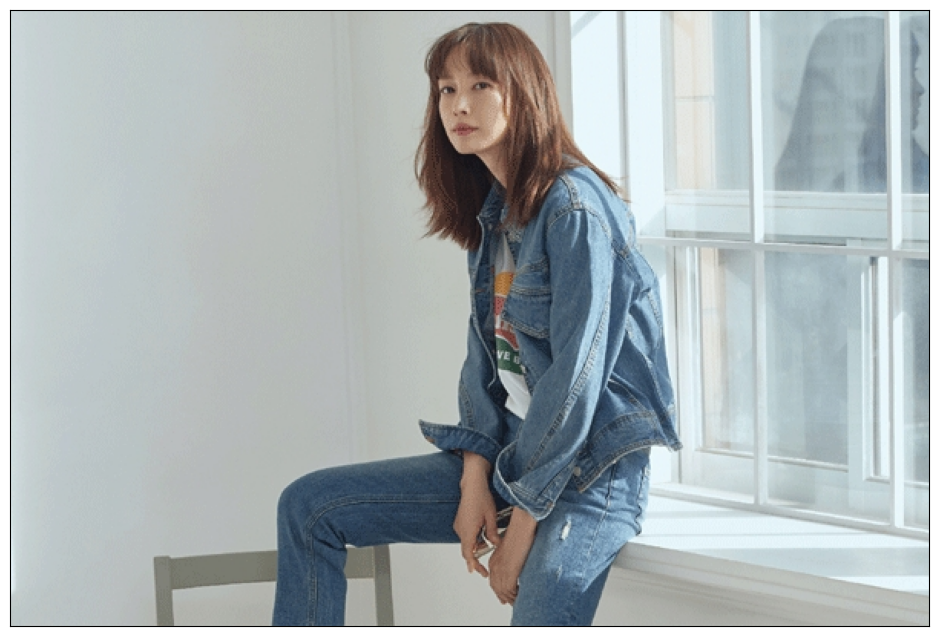

In [4]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('NA.gif')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (12, 8))
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.show()

# III. Intersection Over Union (IOU)

>## 1) Ground Truth

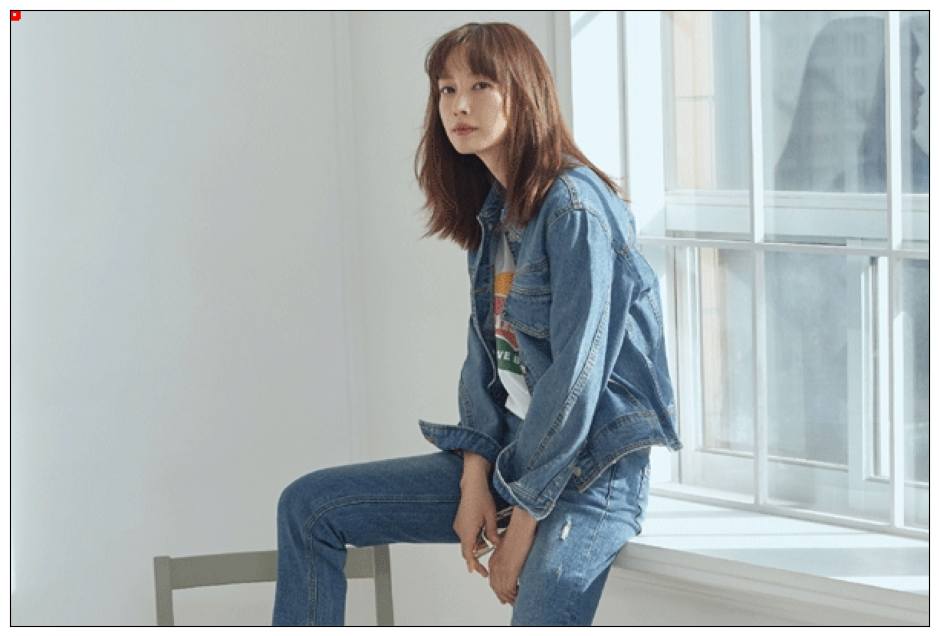

In [8]:
import cv2
import matplotlib.pyplot as plt

gt_box = [0,0,5,5]
#[170, 5, 400, 400]

img = cv2.imread('NA.gif')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

red = (255, 0 , 0)
img_rgb = cv2.rectangle(img_rgb, 
                        (gt_box[0], gt_box[1]), 
                        (gt_box[2], gt_box[3]), 
                        color = red, 
                        thickness = 2)

plt.figure(figsize = (12, 8))
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.show()

>## 2) Define IOU Function

In [ ]:
import numpy as np 

def compute_iou(cand_box, gt_box):

    x1 = np.maximum(cand_box[0], gt_box[0])
    y1 = np.maximum(cand_box[1], gt_box[1])
    x2 = np.minimum(cand_box[2], gt_box[2])
    y2 = np.minimum(cand_box[3], gt_box[3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union = cand_box_area + gt_box_area - intersection
    
    iou = round(intersection / union, 2)
    return iou

>## 3) Get Region Information

In [ ]:
import selectivesearch

img = cv2.imread('NA.gif')
img_rgb2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

_, regions = selectivesearch.selective_search(img_rgb2, 
                                              scale = 1000, 
                                              min_size = 10000)

>## 4) Calculating IOU

In [ ]:
gt_box = [170, 5, 440, 400]

cand_rects = [cand['rect'] for cand in regions]

for index, cand_box in enumerate(cand_rects):
    cand_box = list(cand_box)
    cand_box[2] = cand_box[2] + cand_box[0]
    cand_box[3] = cand_box[3] + cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    print('index:', index, "iou:", iou)

index: 0 iou: 0.4
index: 1 iou: 0.65
index: 2 iou: 0.08
index: 3 iou: 0.03
index: 4 iou: 0.42
index: 5 iou: 0.42


>## 5) 최종 적용

* IOU: 0.3 이상

index: 0 iou: 0.4 rectangle: (0, 0, 348, 401)
index: 2 iou: 0.42 rectangle: (258, 0, 599, 401)
index: 3 iou: 0.42 rectangle: (258, 0, 599, 401)


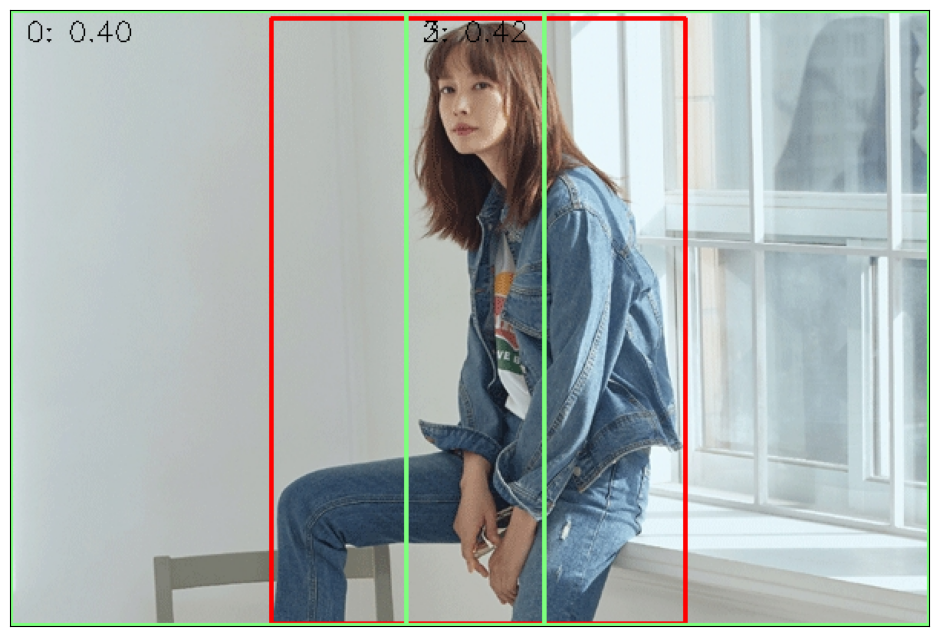

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('NA.gif')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cand_rects = [cand['rect'] for cand in regions if cand['size'] > 50000]

gt_box = [170, 5, 440, 400]
red = (255, 0 , 0)
img_rgb = cv2.rectangle(img_rgb, 
                        (gt_box[0], gt_box[1]), 
                        (gt_box[2], gt_box[3]), 
                        color = red, 
                        thickness = 2)

green_rgb = (125, 255, 125)
black_rgb = (0, 0, 0)
for index, cand_box in enumerate(cand_rects):
    
    cand_box = list(cand_box)
    cand_box[2] = cand_box[2] + cand_box[0]
    cand_box[3] = cand_box[3] + cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    
    if iou > 0.3:
        print('index:', index, "iou:", iou, 'rectangle:',(cand_box[0], cand_box[1], cand_box[2], cand_box[3]))
        cv2.rectangle(img_rgb, 
                      (cand_box[0], cand_box[1]), 
                      (cand_box[2], cand_box[3]), 
                      color = green_rgb, 
                      thickness = 2)
        
        text = "{}: {:.2f}".format(index, iou)
        cv2.putText(img_rgb, 
                    text, 
                    (cand_box[0] + 10, cand_box[1] + 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, 
                    color = black_rgb, 
                    thickness = 1)
    
plt.figure(figsize = (12, 8))
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.show()
    

# 
# 
# 
# The End
# 
# 
# 